In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from collections import Counter
import torchvision

In [9]:
RAW_DIR = Path("C:/IP/greenmlops/data/raw/cifar100")
OUT_DIR = Path("C:/IP/greenmlops/data/processed/cifar100")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [10]:
train_dataset = torchvision.datasets.CIFAR100(
    root=str(RAW_DIR),
    train=True,
    download=False,
    transform=None
)

test_dataset = torchvision.datasets.CIFAR100(
    root=str(RAW_DIR),
    train=False,
    download=False,
    transform=None
)

In [11]:
print(f"Train samples : {len(train_dataset)}")
print(f"Test samples  : {len(test_dataset)}")
print(f"Image size    : {train_dataset[0][0].size}")
print(f"Num classes   : {len(train_dataset.classes)}")

Train samples : 50000
Test samples  : 10000
Image size    : (32, 32)
Num classes   : 100


In [12]:
class_names = train_dataset.classes
print(f"Total classes: {len(class_names)}")
print(class_names[:20])

Total classes: 100
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle']


In [13]:
train_labels = [label for _, label in train_dataset]
label_counts = Counter(train_labels)
counts = [label_counts[i] for i in range(100)]

print(f"Min samples per class : {min(counts)}")
print(f"Max samples per class : {max(counts)}")
print(f"Mean samples per class: {np.mean(counts):.1f}")
print(f"Perfectly balanced    : {min(counts) == max(counts)}")

Min samples per class : 500
Max samples per class : 500
Mean samples per class: 500.0
Perfectly balanced    : True


### PLots


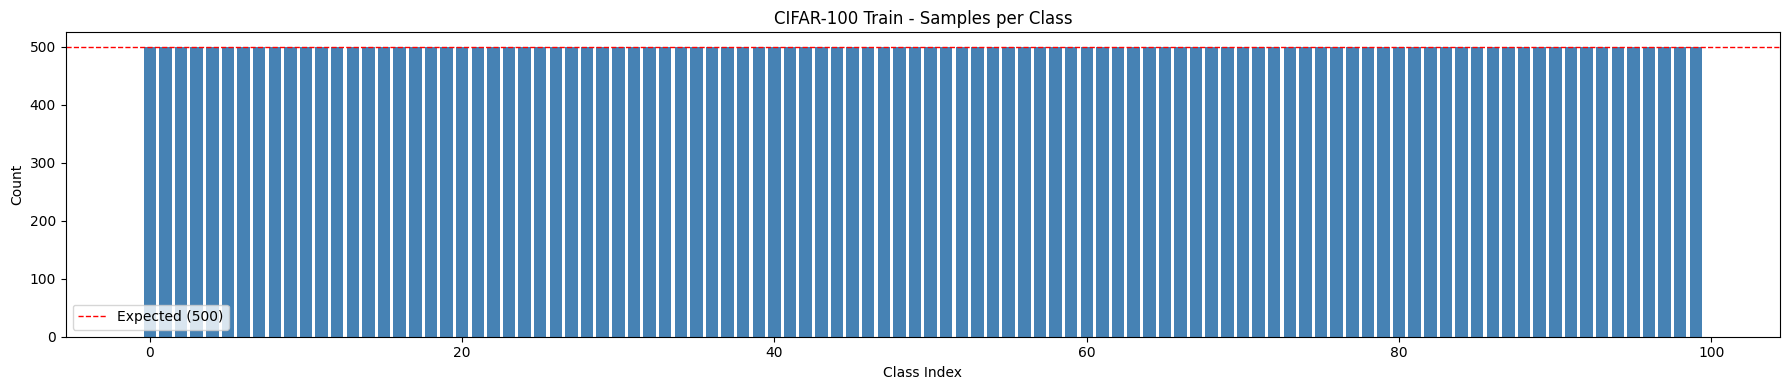

In [14]:
fig, ax = plt.subplots(figsize=(18, 4))
ax.bar(range(100), counts, color="steelblue", width=0.8)
ax.set_title("CIFAR-100 Train - Samples per Class")
ax.set_xlabel("Class Index")
ax.set_ylabel("Count")
ax.axhline(y=500, color="red", linestyle="--", linewidth=1, label="Expected (500)")
ax.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "class_distribution.png", dpi=150)
plt.show()

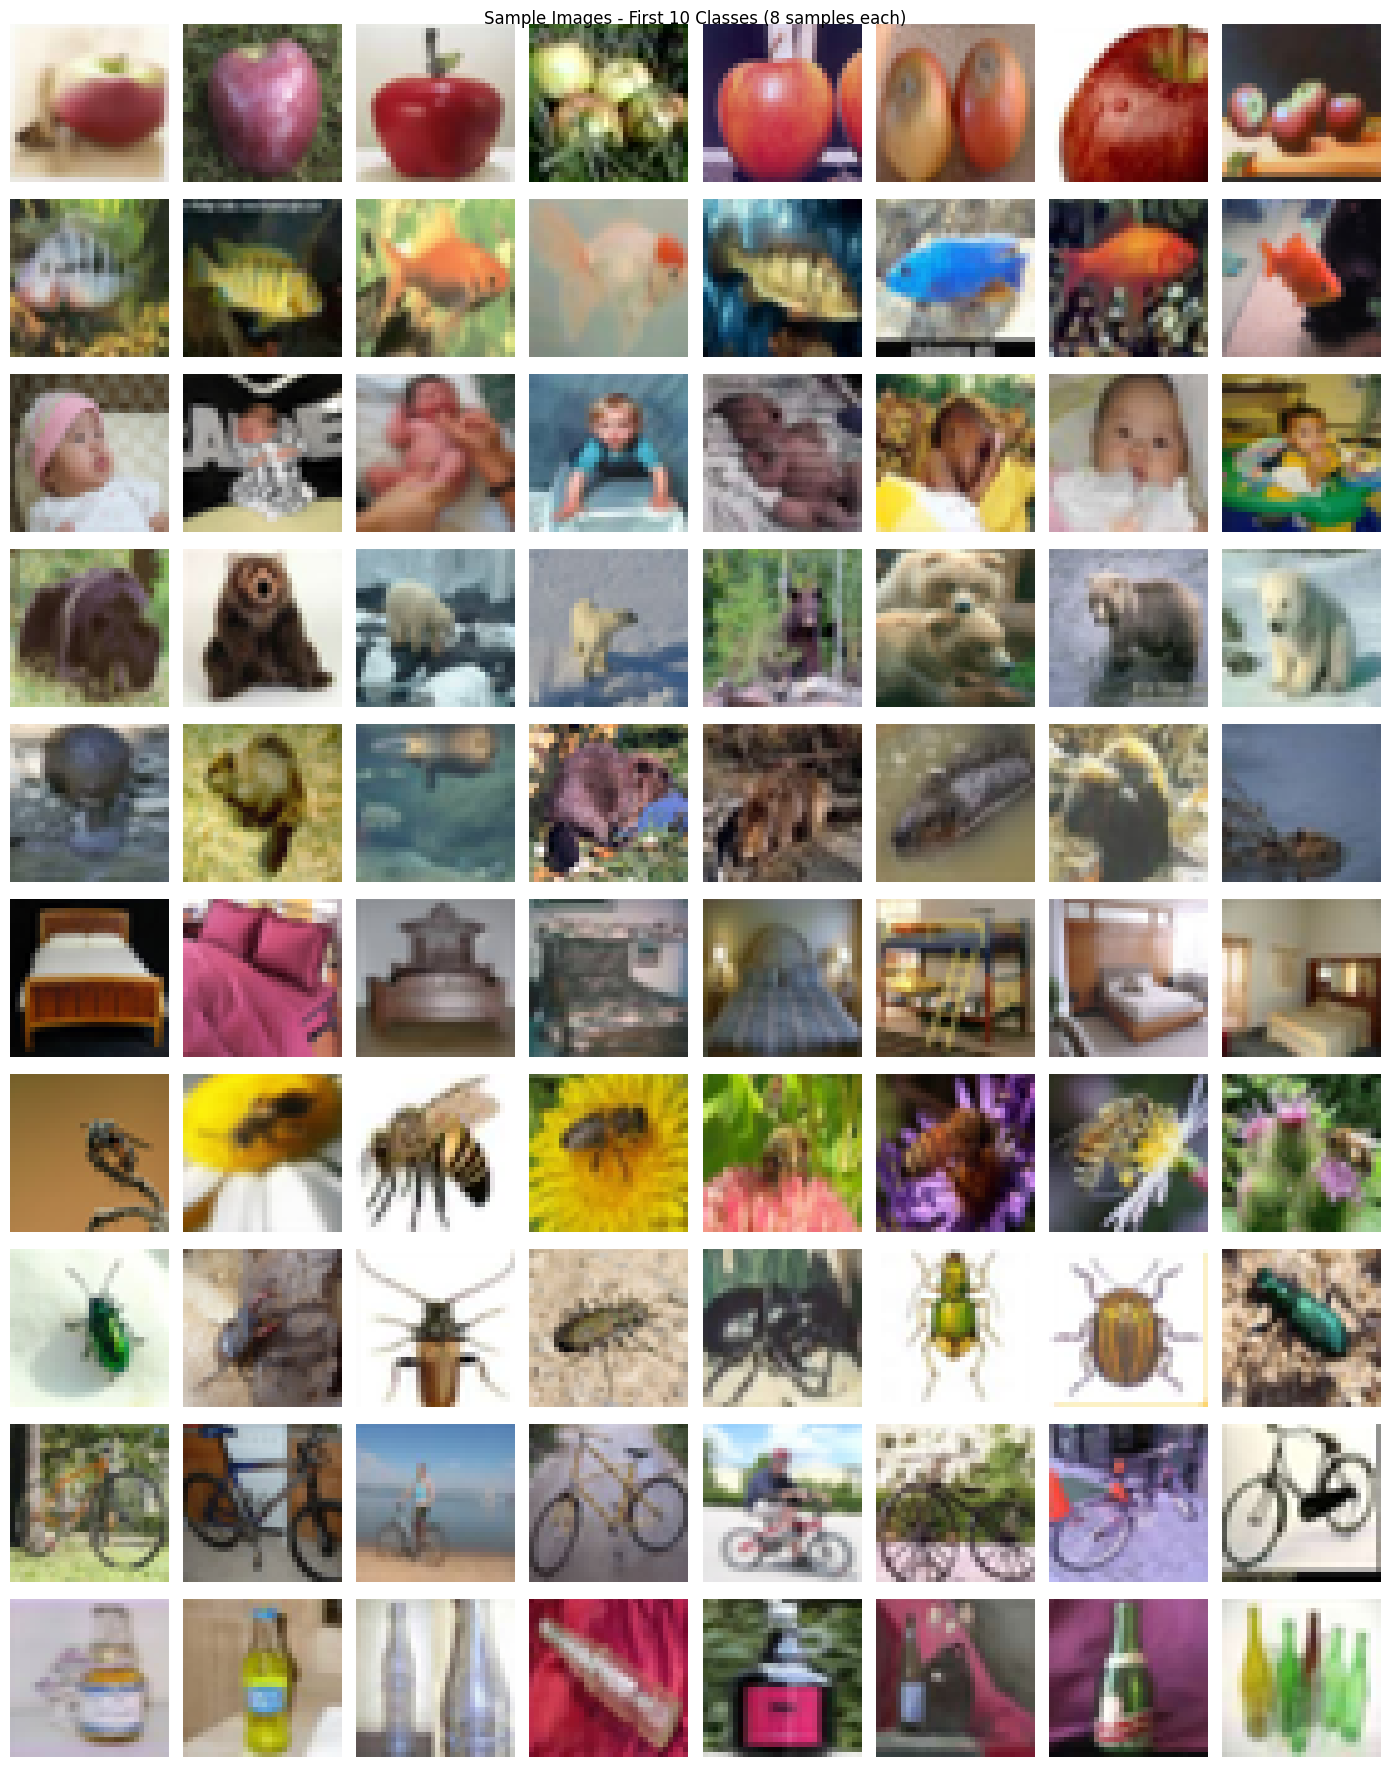

In [15]:
#  so we don't scan full dataset 10 times
from collections import defaultdict

class_index = defaultdict(list)
for img, label in train_dataset:
    if len(class_index[label]) < 8:
        class_index[label].append(img)
    if all(len(v) == 8 for v in class_index.values()) and len(class_index) == 100:
        break

fig, axes = plt.subplots(10, 8, figsize=(14, 18))
for class_idx in range(10):
    for col, img in enumerate(class_index[class_idx]):
        axes[class_idx][col].imshow(img)
        axes[class_idx][col].axis("off")
        if col == 0:
            axes[class_idx][col].set_ylabel(
                class_names[class_idx], fontsize=7, rotation=0, labelpad=40
            )

fig.suptitle("Sample Images - First 10 Classes (8 samples each)", fontsize=12)
plt.tight_layout()
plt.savefig(OUT_DIR / "sample_images.png", dpi=150)
plt.show()

In [16]:
channel_sum = np.zeros(3)
channel_sum_sq = np.zeros(3)
total_pixels = 0

for img, _ in train_dataset:
    arr = np.array(img) / 255.0  # (32, 32, 3)
    channel_sum += arr.mean(axis=(0, 1))
    channel_sum_sq += (arr ** 2).mean(axis=(0, 1))
    total_pixels += 1

channel_mean = channel_sum / total_pixels
channel_std = np.sqrt(channel_sum_sq / total_pixels - channel_mean ** 2)

print("Channel-wise stats (normalized 0-1):")
print(f"  Mean  R={channel_mean[0]:.4f}  G={channel_mean[1]:.4f}  B={channel_mean[2]:.4f}")
print(f"  Std   R={channel_std[0]:.4f}  G={channel_std[1]:.4f}  B={channel_std[2]:.4f}")

Channel-wise stats (normalized 0-1):
  Mean  R=0.5071  G=0.4865  B=0.4409
  Std   R=0.2673  G=0.2564  B=0.2762


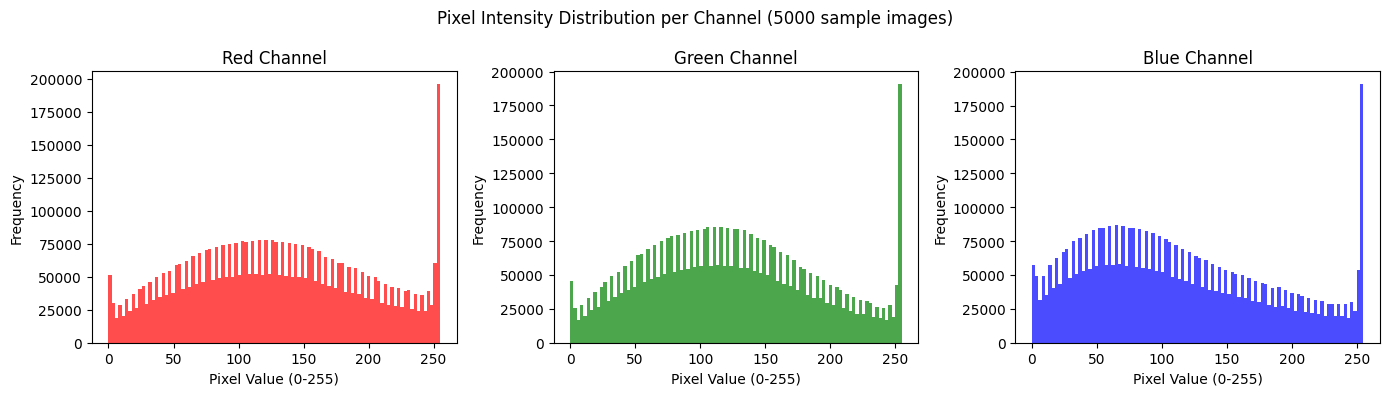

In [17]:
# sample 5000 images to keep histogram fast
sample_indices = np.random.choice(len(train_dataset), size=5000, replace=False)
sample_pixels = np.array([np.array(train_dataset[i][0]) for i in sample_indices])
# shape: (5000, 32, 32, 3)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
channel_names = ["Red", "Green", "Blue"]
colors = ["red", "green", "blue"]

for i in range(3):
    axes[i].hist(sample_pixels[:, :, :, i].flatten(), bins=100, color=colors[i], alpha=0.7)
    axes[i].set_title(f"{channel_names[i]} Channel")
    axes[i].set_xlabel("Pixel Value (0-255)")
    axes[i].set_ylabel("Frequency")

plt.suptitle("Pixel Intensity Distribution per Channel (5000 sample images)")
plt.tight_layout()
plt.savefig(OUT_DIR / "pixel_distribution.png", dpi=150)
plt.show()

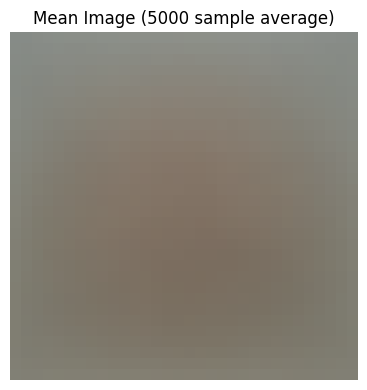

In [18]:
mean_image = sample_pixels.mean(axis=0).astype(np.uint8)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(mean_image)
ax.set_title("Mean Image (5000 sample average)")
ax.axis("off")
plt.tight_layout()
plt.savefig(OUT_DIR / "mean_image.png", dpi=150)
plt.show()

In [19]:
print("=== CIFAR-100 EDA SUMMARY ===")
print(f"Train samples    : {len(train_dataset)}")
print(f"Test samples     : {len(test_dataset)}")
print(f"Classes          : {len(class_names)}")
print(f"Samples per class: {min(counts)} min / {max(counts)} max (balanced: {min(counts)==max(counts)})")
print(f"Image size       : 32x32x3")
print(f"Mean R/G/B       : {channel_mean[0]:.4f} / {channel_mean[1]:.4f} / {channel_mean[2]:.4f}")
print(f"Std  R/G/B       : {channel_std[0]:.4f} / {channel_std[1]:.4f} / {channel_std[2]:.4f}")
print(f"\nSaved plots to   : {OUT_DIR}")

=== CIFAR-100 EDA SUMMARY ===
Train samples    : 50000
Test samples     : 10000
Classes          : 100
Samples per class: 500 min / 500 max (balanced: True)
Image size       : 32x32x3
Mean R/G/B       : 0.5071 / 0.4865 / 0.4409
Std  R/G/B       : 0.2673 / 0.2564 / 0.2762

Saved plots to   : C:\IP\greenmlops\data\processed\cifar100
